## Notebook to build model
Author: Madhura Pande

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import r2_score, mean_absolute_error

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [12]:
train_features = pd.read_csv("../data/dengue_features_train.csv")
train_labels = pd.read_csv("../data/dengue_labels_train.csv")
test_features = pd.read_csv('../data/dengue_features_test.csv')

# combine dataframe
train_df = train_labels.merge(train_features, how='inner', on=['city', 'year', 'weekofyear'])
train_df.shape

# view data for two cities separately
sj_train_df = train_df.loc[train_df['city']=='sj']
iq_train_df = train_df.loc[train_df['city'] == 'iq']
sj_test_df = test_features.loc[test_features['city']=='sj']
iq_test_df = test_features.loc[test_features['city']=='iq']

del train_features, train_labels, train_df

In [13]:
sj_train_df.set_index('week_start_date', inplace=True)
#sj_train_df = sj_train_df.drop(columns='week_start_date')
sj_train_df.head(2)

,city,year,weekofyear,total_cases,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
week_start_date,,,,,,,,,,,,,,,,,,,,,
1990-04-30,sj,1990,18,4,0.1226,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1990-05-07,sj,1990,19,5,0.1699,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6


In [14]:
iq_train_df.set_index('week_start_date', inplace=True)
sj_test_df.set_index('week_start_date', inplace=True)
iq_test_df.set_index('week_start_date', inplace=True)

In [5]:
sj_train_df.columns

Index(['city', 'year', 'weekofyear', 'total_cases', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'],
      dtype='object')

In [15]:
final_features = ['ndvi_ne', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_precip_amt_kg_per_m2'
                , 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k', 'station_precip_mm']

In [16]:
# fit model without exogenous variables
sj_train_endo = sj_train_df[['total_cases']].copy(deep=True)
sj_train_endo = sj_train_endo.sort_index(axis=0)
sj_train_endo.head(2)

,total_cases
week_start_date,
1990-04-30,4
1990-05-07,5


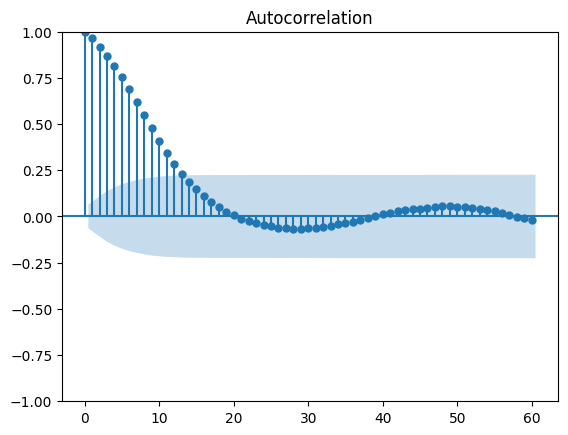

In [8]:
pm.plot_acf(sj_train_endo, alpha=0.05, lags=60)

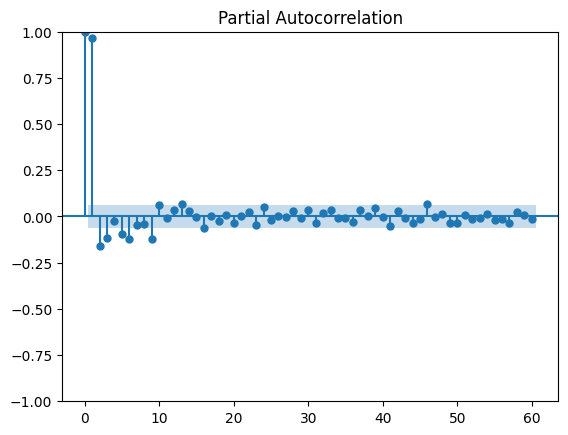

In [18]:
pm.plot_pacf(sj_train_endo,alpha=0.05, lags=60)

In [15]:
from pmdarima.arima.stationarity import ADFTest

adf = ADFTest(alpha=0.05)
p_val, should_diff = adf.should_diff(sj_train_endo['total_cases'])
print("p-val is", p_val)
print("should diff", should_diff)

p-val is 0.01
should diff False


series is not stationary

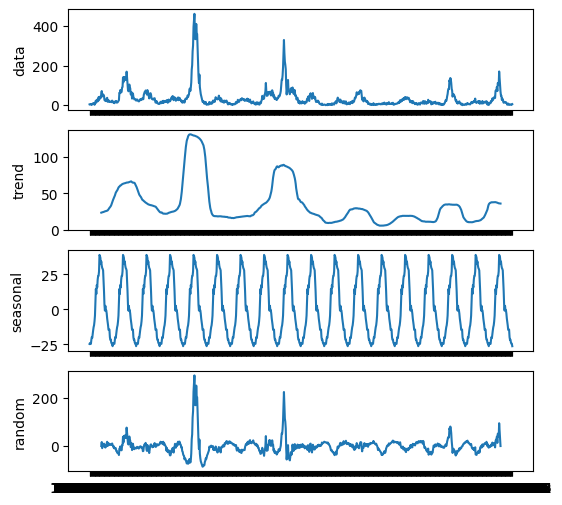

In [17]:
decomposed = pm.decompose(sj_train_endo['total_cases'], type_='additive',m=52,filter_= None)
figure_kwargs = {'figsize': (6, 6)}
pm.utils.visualization.decomposed_plot(decomposed, figure_kwargs=figure_kwargs)

The time difference between the two maximums is 52


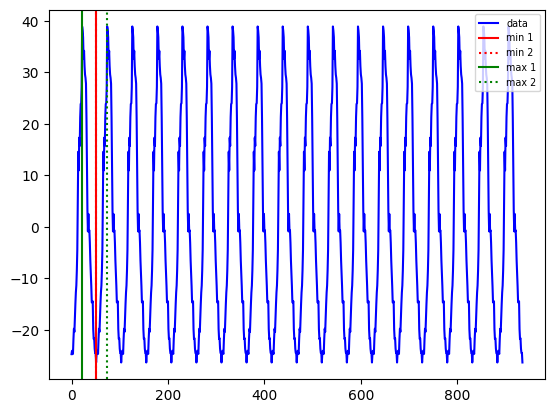

In [76]:
seasonal = pd.DataFrame()
seasonal['data'] = decomposed[2]

ax = seasonal.plot(label='Seasonality', color='blue')
min_ = seasonal.idxmin().values[0]
max_ = seasonal.idxmax().values[0]
min_2 = seasonal[max_:].idxmin().values[0]
max_2 = seasonal[min_2:].idxmax().values[0]
ax.axvline(min_,label='min 1',c='red')
ax.axvline(min_2,label='min 2',c='red', ls=':')
ax.axvline(max_,label='max 1',c='green')
ax.axvline(max_2,label='max 2',c='green', ls=':')
plt.legend(loc='upper right', fontsize='x-small')
print(f'The time difference between the two maximums is {max_2-max_}')

### Build SARIMA model using auto_arima and find optimal p,d,q,P,D,Q values

In [6]:
sj_train, sj_val = train_test_split(sj_train_endo, test_size=0.2, train_size=0.8)

In [82]:
auto_model1 = pm.auto_arima(sj_train, start_p=0, start_q=0, start_P=0, start_Q=0
                            , m=52, seasonal=True, stationary=True, random=True
                            , error_action='warn', trace=True, supress_warnings=True, stepwise=True, n_jobs=-1, random_state=20, n_fits=20 )

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=8122.312, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=6083.317, Time=7.14 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=7340.485, Time=8.34 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=8393.931, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=6081.788, Time=0.07 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=6083.365, Time=4.25 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=9.98 sec
 ARIMA(2,0,0)(0,0,0)[52] intercept   : AIC=6054.328, Time=0.15 sec
 ARIMA(2,0,0)(1,0,0)[52] intercept   : AIC=6055.535, Time=10.09 sec
 ARIMA(2,0,0)(0,0,1)[52] intercept   : AIC=6055.623, Time=5.20 sec
 ARIMA(2,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=16.50 sec
 ARIMA(3,0,0)(0,0,0)[52] intercept   : AIC=6049.874, Time=0.29 sec
 ARIMA(3,0,0)(1,0,0)[52] intercept   : AIC=6051.368, Time=17.39 sec
 ARIMA(3,0,0)(0,0,1)[52] intercept   : AIC=6051.418, Time=10.93 sec
 ARIMA(3,0,0)(1,0,1)[52] 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  748
Model:               SARIMAX(2, 0, 1)   Log Likelihood               -3013.952
Date:                Sat, 16 Mar 2024   AIC                           6037.904
Time:                        21:33:21   BIC                           6060.991
Sample:                             0   HQIC                          6046.801
                                - 748                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5460      0.203      2.696      0.007       0.149       0.943
ar.L1          1.8425      0.029     64.479      0.000       1.786       1.899
ar.L2         -0.8576      0.028    -31.179      0.000      -0.912      -0.804
ma.L1         -0.7612      0.038    -20.268      0.000      -0.835      -0.688
sigma2       184.3650      3.854     47.833      0.000     176.811     191.919
===================================================================================
Ljung-Box (L1) (Q):                   0.92   Jarque-Bera (JB):              3766.18
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               0.13   Skew:                             0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

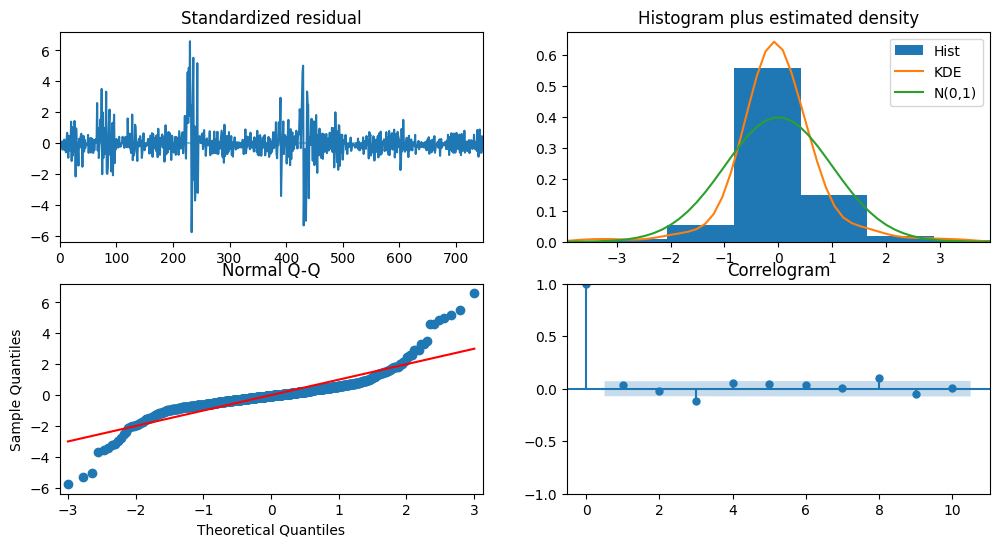

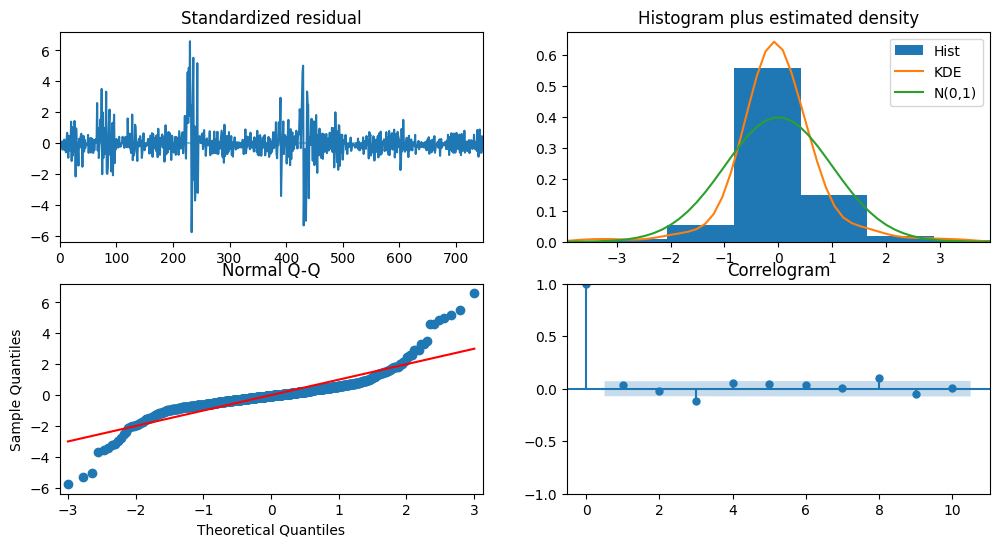

In [83]:
display(auto_model1.summary())
auto_model1.plot_diagnostics(figsize=(12,6))

In [84]:
sj_pred = auto_model1.predict(n_periods=sj_val.shape[0])
sj_pred

748    11.293468
749    12.778027
750    14.404025
751    16.126742
752    17.906363
         ...    
931    36.114962
932    36.114963
933    36.114964
934    36.114965
935    36.114966
Length: 188, dtype: float64

In [85]:
pred_df = pd.DataFrame()
pred_df['total_cases'] = sj_val['total_cases']
pred_df['pred_cases'] = list(sj_pred)
pred_df.head(2)

,total_cases,pred_cases
week_start_date,,
2004-09-16,13,11.293468
2004-09-23,27,12.778027


In [86]:
print(r2_score(y_true=pred_df['total_cases'], y_pred=pred_df['pred_cases']))
print(mean_absolute_error(y_true=pred_df['total_cases'], y_pred=pred_df['pred_cases']))

-0.12212387537752312
27.267166358418887


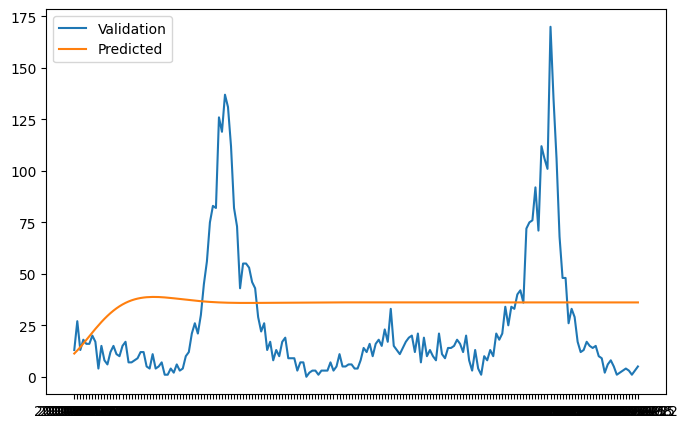

In [87]:
plt.figure(figsize=(8,5))
plt.plot(pred_df['total_cases'],label="Validation")
plt.plot(pred_df['pred_cases'],label="Predicted")
plt.xticks(ticks=pred_df.index)
plt.legend(loc = 'upper left')
plt.show()

### MOdel with exogenous vars

In [ ]:
sj_train_ex, sj_val_ex = train_test_split(sj_train_df, test_size=0.2, train_size=0.8)

auto_model2 = pm.auto_arima(sj_train_ex['total_cases'], X=sj_train_ex[final_features].ffill(), start_p=0, start_q=0, start_P=0, start_Q=0
                            , m=52, seasonal=True, stationary=True, random=True
                            , error_action='warn', trace=True, supress_warnings=True, stepwise=True, n_jobs=-1, random_state=20, n_fits=20)

In [91]:
auto_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  748
Model:               SARIMAX(3, 0, 0)   Log Likelihood               -3048.028
Date:                Sat, 16 Mar 2024   AIC                           6120.056
Time:                        22:38:15   BIC                           6175.465
Sample:                             0   HQIC                          6141.409
                                - 748                                         
Covariance Type:                  opg                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
ndvi_ne                                 -12.3907      6.402     -1.936      0.053     -24.938       0.156
ndvi_sw                                  56.7975      8.270      6.868      0.000      40.588      73.007
precipitation_amt_mm                     -0.0104      0.012     -0.845      0.398      -0.034       0.014
reanalysis_air_temp_k                     0.0073      0.061      0.120      0.905      -0.112       0.126
reanalysis_precip_amt_kg_per_m2           0.0005      0.017      0.028      0.977      -0.033       0.034
reanalysis_specific_humidity_g_per_kg     1.1804      0.772      1.528      0.126      -0.333       2.694
reanalysis_tdtr_k                         2.3895      1.244      1.921      0.055      -0.048       4.827
station_precip_mm                         0.0008      0.018      0.046      0.964      -0.034       0.036
ar.L1                                     1.0671      0.020     54.427      0.000       1.029       1.106
ar.L2                                    -0.0068      0.032     -0.216      0.829      -0.069       0.055
ar.L3                                    -0.1135      0.017     -6.840      0.000      -0.146      -0.081
sigma2                                  199.3549      5.284     37.729      0.000     188.999     209.711
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              2585.18
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.15   Skew:                             0.91
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [96]:
sj_pred2 = auto_model2.predict(n_periods=sj_val_ex.shape[0],X=sj_val_ex[final_features].ffill())
sj_pred2.shape

(188,)

In [98]:
pred_df['pred_cases2'] = list(sj_pred2)

In [99]:
print(r2_score(y_true=pred_df['total_cases'], y_pred=pred_df['pred_cases2']))
print(mean_absolute_error(y_true=pred_df['total_cases'], y_pred=pred_df['pred_cases2']))

-0.0416765773926
26.229532086374697


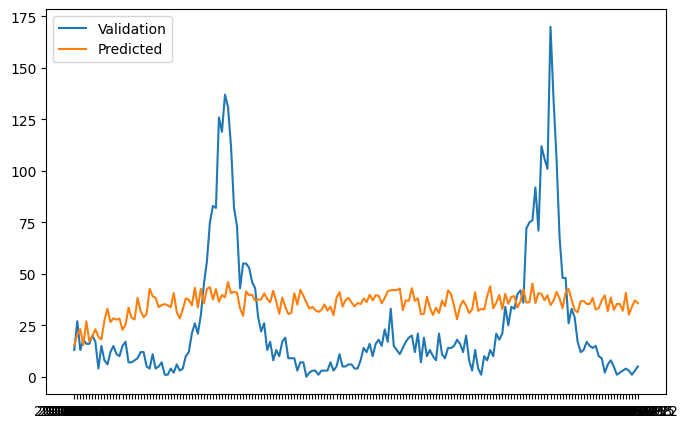

In [100]:
plt.figure(figsize=(8,5))
plt.plot(pred_df['total_cases'],label="Validation")
plt.plot(pred_df['pred_cases2'],label="Predicted")
plt.xticks(ticks=pred_df.index)
plt.legend(loc = 'upper left')
plt.show()

#### Transform data and remodel

In [18]:
# use Box-Cox transformation
y = [val if val>0 else 1 for val in sj_train_endo['total_cases']]

transformer = pm.preprocessing.BoxCoxEndogTransformer()
#bc_model = transformer.fit(y)
sj_train_endo_transf,_ = transformer.fit_transform(y)
sj_train_endo_transf[:3]

array([1.40855983, 1.63949967, 1.40855983])

In [19]:
sj_train_bc, sj_test_bc = sj_train_endo_transf[:750],sj_train_endo_transf[750:]
auto_model3 = pm.auto_arima(sj_train_bc, start_p=0, start_q=0, start_P=0, start_Q=0
                            , m=52, seasonal=True, stationary=True, random=True
                            , error_action='warn', trace=True, supress_warnings=True, stepwise=True, n_jobs=-1, random_state=20, n_fits=10 )

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=2375.934, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=985.153, Time=12.18 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=1757.978, Time=6.99 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3935.070, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=983.902, Time=0.24 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=985.278, Time=5.63 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=20.38 sec
 ARIMA(2,0,0)(0,0,0)[52] intercept   : AIC=927.109, Time=0.18 sec
 ARIMA(2,0,0)(1,0,0)[52] intercept   : AIC=927.288, Time=15.26 sec
 ARIMA(2,0,0)(0,0,1)[52] intercept   : AIC=927.647, Time=7.20 sec
 ARIMA(2,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=21.71 sec
 ARIMA(3,0,0)(0,0,0)[52] intercept   : AIC=906.919, Time=0.52 sec
 ARIMA(3,0,0)(1,0,0)[52] intercept   : AIC=904.840, Time=18.74 sec
 ARIMA(3,0,0)(2,0,0)[52] intercept   : AIC=896.360, Time=151.89 sec
 ARIMA(3,0,0)(2,0,1)[52] interc

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  750
Model:             SARIMAX(4, 0, 0)x(2, 0, 0, 52)   Log Likelihood                -435.835
Date:                            Mon, 18 Mar 2024   AIC                            887.670
Time:                                    00:09:56   BIC                            924.631
Sample:                                         0   HQIC                           901.912
                                            - 750                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1059      0.030      3.476      0.001       0.046       0.166
ar.L1          0.5730      0.031   

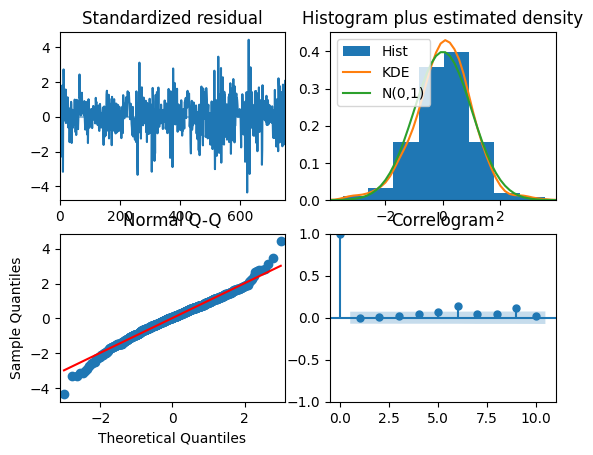

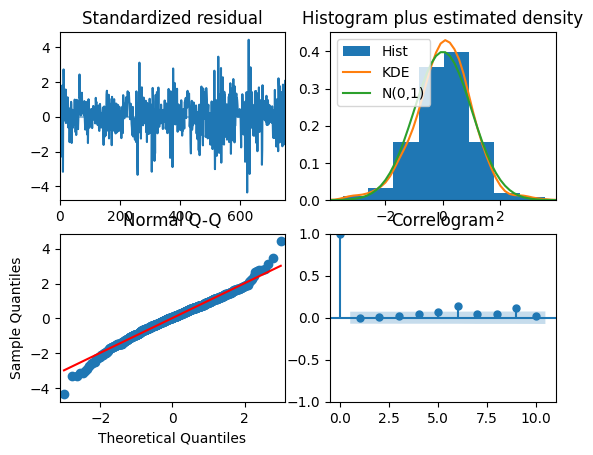

In [21]:
print(auto_model3.summary())
auto_model3.plot_diagnostics()

In [26]:
sj_pred_bc = auto_model3.predict(n_periods=len(sj_test_bc))
sj_pred_bc_inv = transformer.inverse_transform(sj_pred_bc)
sj_pred_bc_inv[0][:5]

array([21.1974376 , 19.85793736, 18.39864908, 19.69856131, 21.3034536 ])

In [27]:
print(r2_score(y_true=sj_test_bc, y_pred=sj_pred_bc_inv[0]))
print(mean_absolute_error(y_true=sj_test_bc, y_pred=sj_pred_bc_inv[0]))

-170.71527737513978
15.682386895703834


Above score is lower than benchmark model

## Similar technique can be used to build model and make prediction for 'iq'

Further improvements may be made with feature enginnering using time information and exogenous variables or by using more sophisticated models